# Vision Transformer for Noise Classification

## Imports

In [1]:
!pip install jax flax optax matplotlib --quiet

In [ ]:
import jax
import jax.numpy as jnp

import flax
import flax.linen as nn
from flax.training import train_state

import optax

import matplotlib.pyplot as plt

from typing import Any, Optional
from tqdm import tqdm

## Vision Transformer

In [ ]:
class MLPBlock(nn.Module):
  hidden_size: int

  @nn.compact
  def __call__(self, x):

    output_shape =  x.shape[-1]

    x = nn.Dense(features=self.hidden_size)(x)
    x = nn.gelu(x)
    x = nn.Dense(features=output_shape)(x)

    return x

class EncoderBlock(nn.Module):
  n_heads: int
  input_size: int
  mlp_size: int

  @nn.compact
  def __call__(self, x):
    y = nn.LayerNorm(name='input_norm')(x)
    y = nn.MultiHeadDotProductAttention(num_heads=self.n_heads)(x)
    x = x + y
    norm_output = nn.LayerNorm(name='attention_norm')(x)
    y = MLPBlock(hidden_size=self.mlp_size)(x)
    return x + y

class VisionTransformer(nn.Module):
    n_layers: int
    n_heads: int
    n_classes: int
    mlp_size: int
    patch_size: int

    @nn.compact
    def __call__(self, image):
        patch_size = self.patch_size

        H, W, C = image.shape[1], image.shape[2], image.shape[3]
        n_patches = (H // patch_size) * (W // patch_size)

        image = image.reshape(image.shape[0], H // patch_size, patch_size, W // patch_size, patch_size, C)
        image = image.transpose(0, 1, 3, 2, 4, 5)
        image = image.reshape(image.shape[0], n_patches, -1)

        embedding = nn.Dense(image.shape[-1])(image)

        pe = self.param('pos_embedding', nn.initializers.normal(), (1, n_patches, image.shape[-1]))
        x = embedding + pe

        for _ in range(self.n_layers):
            x = EncoderBlock(input_size=image.shape[-1],
                             n_heads=self.n_heads,
                             mlp_size=self.mlp_size)(x)

        x = nn.LayerNorm()(x)
        x = x.mean(axis=1)
        x = nn.Dense(self.n_classes)(x)

        return jax.nn.softmax(x)


## Noise datasets

For the details of generating Perlin noise see https://en.wikipedia.org/wiki/Perlin_noise

<Figure size 6400x200 with 0 Axes>

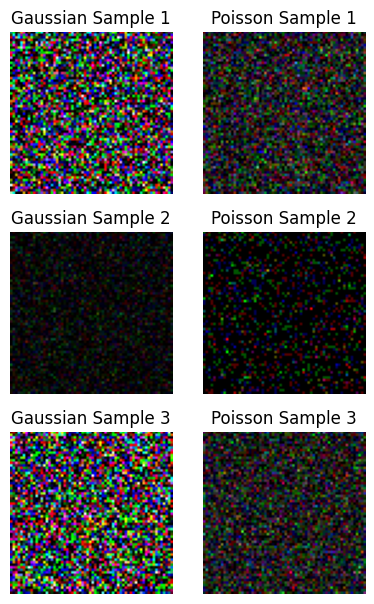

In [ ]:
noise_key, perlin_key, init_key, shuffle_key = jax.random.split(jax.random.PRNGKey(0), 4)
image_shape=(1, 64, 64, 3)
n_samples = 64

gaussian_samples = []
poisson_samples = []

fig = plt.figure(figsize=(n_samples, 2))

for _ in range(n_samples):
    noise_key, gaussian_key, poisson_key, intensity_key = jax.random.split(noise_key, 4)

    intensity = jax.random.uniform(intensity_key)

    gaussian_samples.append(jax.random.normal(gaussian_key, image_shape) * intensity)
    poisson_img = jax.random.poisson(poisson_key, intensity, image_shape)

    max_val = poisson_img.max()
    if max_val > 1e-3:
        poisson_img_normalized = poisson_img / max_val
    else:
        poisson_img_normalized = poisson_img

    poisson_samples.append(poisson_img_normalized)

gaussian_samples = jnp.array(gaussian_samples)
poisson_samples = jnp.array(poisson_samples)

all_samples = jnp.concatenate((gaussian_samples, poisson_samples), axis=0)
all_labels = jnp.concatenate((jnp.zeros(len(gaussian_samples)), jnp.ones(len(poisson_samples))), axis=0)

n_rows = n_samples
n_cols = 2

fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))

for i in range(3):
    plt.subplot(n_rows, n_cols, 2 * i + 1)
    plt.imshow(gaussian_samples[i].squeeze())
    plt.title(f'Gaussian Sample {i+1}')
    plt.axis('off')

    plt.subplot(n_rows, n_cols, 2 * i + 2)
    plt.imshow(poisson_samples[i].squeeze())
    plt.title(f'Poisson Sample {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def create_jax_dataset(shuffle_key, samples, labels, batch_size):
    indices = jnp.arange(samples.shape[0])
    jax.random.shuffle(shuffle_key, indices)
    samples, labels = samples[indices], labels[indices]

    for i in range(0, len(samples), batch_size):
        yield {
            'image': samples[i:i + batch_size],
            'label': labels[i:i + batch_size]
        }

batch_size = 32
dataset = list(create_jax_dataset(shuffle_key, all_samples, all_labels, batch_size))


<ipython-input-100-ef2dbdf63ac2>:3: DeprecationWarning: jax.random.shuffle is deprecated. Use jax.random.permutation with independent=True.
  jax.random.shuffle(shuffle_key, indices)


## Training

In [ ]:
class TrainState(train_state.TrainState):
  batch_stats: Any

def train_step(state: train_state.TrainState, batch):
  def loss_fn(params):
    logits, updates = state.apply_fn(
      {'params': params, 'batch_stats': state.batch_stats},
      x=batch['image'], train=True, mutable=['batch_stats'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=batch['label'])
    return loss, (logits, updates)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  metrics = {
    'loss': loss,
    'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label']),
  }
  return state, metrics

In [ ]:
n_epochs = 5
init_image = jnp.ones(image_shape)

model = VisionTransformer(n_layers=12, n_heads=8, mlp_size=2048, n_classes=3, patch_size=16)

optimizer = optax.adam(learning_rate=0.001)
params, batch_stats = model.init(init_key, init_image)
opt_state = optimizer.init(variables)

state = TrainState(
    step=train_step,
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
    batch_stats=batch_stats,
    opt_state=opt_state
)

losses = []
accuracies = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    epoch_accuracies = []
    for batch in dataset:
      state, metrics = train_step(state, batch)
      epoch_losses.append(metrics['loss'])
      epoch_accuracies.append(metrics['accuracy'])

    avg_loss = np.mean(epoch_losses)
    avg_accuracy = np.mean(epoch_accuracies)
    losses.append(avg_loss)
    accuracies.append(avg_accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {avg_accuracy}")


ValueError: ignored